In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import random
from tqdm import tqdm

In [2]:
random.seed(42)
state = random.getstate()
random.setstate(state=state)

In [3]:
np.random.seed(42)
np_state = np.random.get_state()
np.random.set_state(np_state)

In [4]:
def choose_frequency():
    marker = int(random.random() * 4)
    choices = {0: 'daily', 1: 'weekly', 2: 'monthly', 3: 'rarely'}
    return choices.get(marker, 3)

In [5]:
choose_frequency()

'monthly'

In [6]:
def choose_sector():
    marker = int(random.random() * 5)
    choices = {0: 'tech', 1: 'healthcare', 2: 'finance', 3: 'consumer_goods', 4: 'uniform'}
    return choices.get(marker, 4)

In [7]:
choose_sector()

'tech'

In [8]:
def choose_buy_price(row):
    return np.random.uniform(row['Low'], row['High'])

In [9]:
def choose_sell_price(row, buy_price):
    return np.random.uniform(buy_price, row['High'])

In [10]:
def get_dividends(row):
    return row['Dividends'].item()

In [11]:
def generate_sum_split(target, count=5, min_value=None, max_value=None, max_attempts=100):
    if min_value is None:
        min_value = 0
    if max_value is None:
        max_value = target

    if min_value * count > target or max_value * count < target:
        raise ValueError("Impossible to generate splits within given constraints")

    for attempt in range(max_attempts):
        # Generate count-1 random points between 0 and target
        points = sorted([random.uniform(0, target) for _ in range(count-1)])
        points = [0] + points + [target]
        
        # Calculate differences between adjacent points
        result = [points[i+1] - points[i] for i in range(count)]
        
        # Check if all splits are within the specified range
        if all(min_value <= split <= max_value for split in result):
            return result

    raise ValueError(f"Failed to generate valid split after {max_attempts} attempts")

In [12]:
def calculate_portfolio_value(holdings, stocks_data, date):
    total_value = 0
    for stock, shares in holdings.items():
        for sector, stocks in stocks_data.items():
            if stock in stocks:
                data = stocks[stock]
                if date in data['Date'].values:
                    close_price = data.loc[data['Date'] == date, 'Close'].values[0]
                    total_value += shares * close_price
                break
    return total_value

In [13]:
def create_portfolio(portfolio_id, sectors, start_date, end_date, stocks_data, freq_dict):
    portfolio = []

    frequency = choose_frequency()
    main_sector = choose_sector()
    remain_sectors = sectors.copy()

    # set sector probabilities
    if main_sector != 'uniform':
        sector_focus = random.uniform(0.6, 0.8)
        remainder = 1.0 - sector_focus
        remain_sectors.remove(main_sector)
        splits = generate_sum_split(target=remainder, count=len(remain_sectors))
        sector_splits = {main_sector: sector_focus}
        for i, sec in enumerate(remain_sectors):
            sector_splits[sec] = splits[i]
    else:
        splits = generate_sum_split(target=1.0, count=len(remain_sectors), min_value=0.10, max_value=0.40)
        sector_splits = {}
        for i, sec in enumerate(remain_sectors):
            sector_splits[sec] = splits[i]
    
    # normalize probabilities
    total_probs = sum(sector_splits.values())
    sector_probs = {key: value / total_probs for key, value in sector_splits.items()}
        
    current_holdings = {stock: 0 for sector, stocks in stocks_data.items() for stock in stocks}
    current_investments = {stock: 0 for sector, stocks in stocks_data.items() for stock in stocks}
    date = pd.to_datetime(start_date).date()
    end_date = pd.to_datetime(end_date).date()
    while date <= end_date:
        # choose sector
        sector = random.choices(list(sector_probs.keys()), weights=sector_probs.values(), k=1)[0]
        
        # randomly pick a stock from that sector
        stock = random.choice(list(stocks_data[sector].keys()))
        data = stocks_data[sector][stock]
        # date time format
        data['Date'] = pd.to_datetime(data['Date']).dt.date
        if (date in data['Date'].values):
            returns = 0

            buy_price = choose_buy_price(data.loc[data['Date'] == date])[0]
            buy_vol = random.uniform(freq_dict[frequency][0], freq_dict[frequency][1])
            sell_price = choose_sell_price(data.loc[data['Date'] == date], buy_price)[0]
            sell_vol = random.uniform(freq_dict[frequency][0], freq_dict[frequency][1])
            dividends = get_dividends(data.loc[data['Date'] == date])
            
            # update current holdings
            current_holdings[stock] += buy_vol
            current_investments[stock] += buy_vol * buy_price

            # choose to sell or not, say 25% inclination in a day to sell
            sell_chance = (random.random() < 0.25)
            if sell_chance and sell_vol <= current_holdings[stock]:
                current_holdings[stock] -= sell_vol
                current_investments[stock] -= sell_vol * buy_price
                returns += sell_vol * (sell_price - buy_price)
            else:
                sell_price = 0.0
                sell_vol = 0.0
            
            # if sell everything at that day close price
            portfolio_value = calculate_portfolio_value(current_holdings, stocks_data, date)
            total_curr_investments = sum(value for value in current_investments.values())
            returns = returns + portfolio_value - total_curr_investments + dividends
            portfolio.append([date, stock, sector, buy_price, buy_vol, sell_price, sell_vol, data.loc[data['Date'] == date, 'Dividends'].item(), current_holdings[stock], total_curr_investments, returns])
            
            # add time skip
            gap = freq_dict[frequency][-1]
            delta = random.uniform(0.9*gap, 1.1*gap+1)
            date = date + timedelta(days=int(delta))
        else:
            date = date + timedelta(days=1)
            
    
    df = pd.DataFrame(portfolio, columns=['Date', 'Symbol', 'Sector', 'Buy Price', 'Buy Volume', 'Sell Price', 'Sell Volume', 'Dividends', 'Stock Shares', 'Investment Total', 'Returns'])
    df.to_csv(f'Portfolios/{main_sector}/{portfolio_id}.csv', index=False)
    return main_sector

In [14]:
main_sectors = {'tech', 'finance', 'healthcare', 'consumer_goods', 'uniform'}
for sec in main_sectors:
    base = 'Portfolios'
    directory = os.path.join(base, sec)
    if not os.path.exists(directory):
        os.makedirs(directory)

In [15]:
# trade volume ranges and day skips dictated by frequency
freq_dict = {'daily': (0, 1, 1), 'weekly': (0.5, 5, 7), 'monthly': (3, 15, 30), 'rarely': (0, 15, 90)}

sectors = {'tech', 'finance', 'healthcare', 'consumer_goods'}

In [16]:
stocks_data = {}
base_dir = 'Historical'
for sector in os.listdir(base_dir):
    sector_path = os.path.join(base_dir, sector)
    
    # Check if it's a directory
    if os.path.isdir(sector_path):
        # Initialize the sector key in the dictionary
        stocks_data[sector] = {}
    
        for filename in os.listdir(sector_path):
            if filename.endswith('.csv'):
                stock_symbol = filename.split('_')[0]
                file_path = os.path.join(sector_path, filename)
                # load the csv file 
                stocks_data[sector][stock_symbol] = pd.read_csv(file_path)

In [17]:
total = 200
samples = np.arange(1, total + 1)
sector_counts = {}
for i in tqdm(samples, total=len(samples)):
    name = f'portfolio_{i}'
    main_sector = create_portfolio(name, sectors, datetime(2021, 1, 1), datetime(2023, 12, 31), stocks_data, freq_dict)
    sector_counts[main_sector] = sector_counts.get(main_sector, 0) + 1
    
print(sector_counts)

100%|██████████| 200/200 [07:22<00:00,  2.21s/it]

{'healthcare': 47, 'finance': 42, 'uniform': 38, 'tech': 41, 'consumer_goods': 32}


In [18]:
portfolios = {}

base_dir = 'Portfolios'
for sector in os.listdir(base_dir):
    sector_path = os.path.join(base_dir, sector)
    if os.path.isdir(sector_path):
        for pf_name in os.listdir(sector_path):
            pf_path = os.path.join(sector_path, pf_name)
            data = pd.read_csv(pf_path)
            name = pf_name.split('.')[0]
            portfolios[name] = data

print(len(portfolios))

200


In [19]:
portfolio_stats = []

for pf_name, pf_data in portfolios.items():
    # avg gap
    pf_data['Date'] = pd.to_datetime(pf_data['Date']).dt.date
    avg_gap = (pf_data['Date'].diff().mean()).days
    
    # sector partiality
    sector_to_number = {'tech': 0, 'finance': 1, 'healthcare': 2, 'consumer_goods': 3}
    sector_counts = pf_data['Sector'].value_counts()
    total_entries = len(pf_data)
    sector_percentages = sector_counts / total_entries

    # deviation from uniform distribution
    uniform_percentage = 1 / len(sector_to_number)
    deviations = {sector: sector_percentages.get(sector, 0) - uniform_percentage for sector in sector_to_number.keys()}
    
    # sector with the maximum positive deviation indicator
    max_deviation_sector = max(deviations, key=lambda k: deviations[k])
    max_deviation = deviations[max_deviation_sector]
    
    # Combine the signed indicator with the sector number
    sector_indicator = max_deviation + sector_to_number[max_deviation_sector]

    # avg buy/sell stats
    avg_buy_price = pf_data['Buy Price'].mean()
    avg_buy_vol = pf_data['Buy Volume'].mean()
    avg_sell_price = pf_data['Sell Price'].mean()
    avg_sell_vol = pf_data['Sell Volume'].mean()

    avg_dividends = pf_data['Dividends'].mean()

    # total investments over the period
    total_investment = pf_data['Investment Total'].iloc[-1]

    portfolio_stats.append([pf_name, avg_gap, sector_indicator, avg_buy_price, avg_buy_vol, avg_sell_price, avg_sell_vol, avg_dividends, total_investment])
    
pf_stats_df = pd.DataFrame(portfolio_stats, columns=['Porfolio Index', 'Frequency', 'Sector', 'Buy Price', 'Buy Volume', 'Sell Price', 'Sell Volume', 'Dividends', 'Total Investment'])
pf_stats_df.to_csv('Portfolio_stats.csv', index=False)

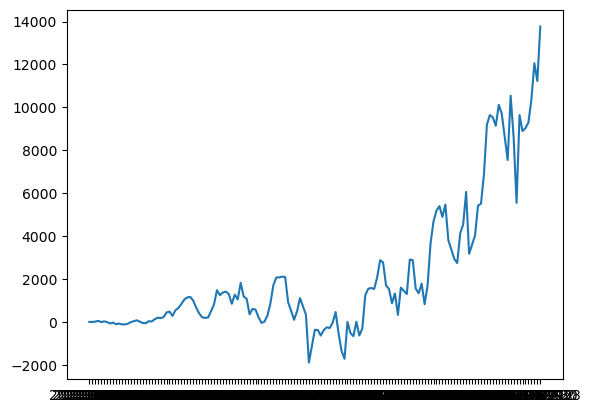

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('Portfolios/healthcare/portfolio_1.csv')

plt.figure()
plt.plot(df['Date'], df['Returns'])
plt.show()